In [85]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import statsmodels.api as sm
from helpers import *

data_folder = 'DATA/'
plot_folder = 'plots/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# load data
movie_data = pd.read_pickle(data_folder + "movie_data_final.pickle")
characters_data = pd.read_pickle(data_folder+'final.pickle')
# define genres to analyse
genres = ['Action', 'Adventure', 'Western', 'Musical', 'Drama', 'Horror']

In [87]:
#adding the decade for analyses (this should also be moved in the data construction)
characters_data['decade'] = ((characters_data['release_date'].astype(int))//10)*10

# Anabel's Analysis

In [88]:
# merge movie genres with characters data to anaylse per genre
characters_with_genre = pd.merge(characters_data, movie_data[['IMDB_ID','genre']], how='left', on='IMDB_ID')
characters_with_genre

,character_ID,wikipedia_ID,freebase_ID,actor_ethnicity,actor_name,personnas,IMDB_ID,character_name,actor_gender,box_office_revenue,name,release_date,actor_age,Verbs,Adjectives,Nouns,Chunks,decade,genre
0,1,975900.0,/m/03vyhn,NaN,wanda de jesus,NaN,tt0228333,Akooshay,F,NaN,Ghosts of Mars,2001.0,42.0,"[discovered, created, wiped]","[second, 22nd, ancient, fierce]","[Set, century, film, miners, Martian, miners, ...","[[(Set, NNP)], (second, JJ), (22nd, JJ), (cent...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
1,2,975900.0,/m/03vyhn,/m/044038p,natasha henstridge,NaN,tt0228333,Lieutenant Melanie Ballard,F,14010832.0,Ghosts of Mars,2001.0,27.0,"[terraformed, allowing, become, authority, sen...","[matriarchal, police, second, second, small, s...","[film, depicts, Mars, positions, story, concer...","[(film, NN), (depicts, NNS), (Mars, NNP), (84,...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
2,3,975900.0,/m/03vyhn,/m/0x67,ice cube,NaN,tt0228333,Desolation Williams,M,14010832.0,Ghosts of Mars,2001.0,32.0,"[wearing, become, named, named, held, mining, ...","[transport, remote, ancient, horrific, team, d...","[pressure, suits, society, prisoner, Williams,...","[(wearing, VBG), (pressure, NN), (suits, NNS),...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
3,4,975900.0,/m/03vyhn,NaN,jason statham,NaN,tt0228333,Sgt Jericho Butler,M,14010832.0,Ghosts of Mars,2001.0,34.0,"[walk, wearing, sent, opened, released, posses...","[second, pick, disembodied, possible, Unfortun...","[half, humans, surface, pressure, suits, team,...","[(second, JJ), (half, NN), (22nd, CD), (humans...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
4,5,975900.0,/m/03vyhn,NaN,clea duvall,NaN,tt0228333,Bashira Kincaid,F,NaN,Ghosts of Mars,2001.0,23.0,"[killed, returning, blame, cot, escapes, leaving]",[massacre],"[pick, transport, prisoner, Desolation, Willia...","[(pick, NN), (transport, NN), (prisoner, NN), ...",2000,"[Thriller, Supernatural, Action, Adventure, Ho..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336453,336454,NaN,NaN,NaN,caleb silvers,NaN,tt9914522,Evan,M,NaN,The Holden Family Plan,2019.0,24.0,"[make, regarding]",[new],"[Mackenzie, husband, decision]","[[(Mackenzie, NNP)], (new, JJ), (husband, NN),...",2010,[Drama]
336454,336455,NaN,NaN,NaN,bethany hazelitt,NaN,tt9914522,Mackenzie,F,NaN,The Holden Family Plan,2019.0,29.0,"[murdered, regarding, make, regarding]","[new, niece]","[Holden, sister, brother, law, husband, Evan, ...","[[(Holden, NNP)], (sister, NN), (brother, NN),...",2010,[Drama]
336455,336456,NaN,NaN,NaN,joshua bootz,NaN,tt9914522,Evan's dad,M,NaN,The Holden Family Plan,2019.0,NaN,"[make, regarding, regarding]",[new],"[Mackenzie, husband, decision, make, niece]","[[(Mackenzie, NNP)], (new, JJ), (husband, NN),...",2010,[Drama]
336456,336457,NaN,NaN,NaN,vince camaj,NaN,tt9914522,Todd,M,NaN,The Holden Family Plan,2019.0,NaN,NaN,NaN,NaN,NaN,2010,[Drama]


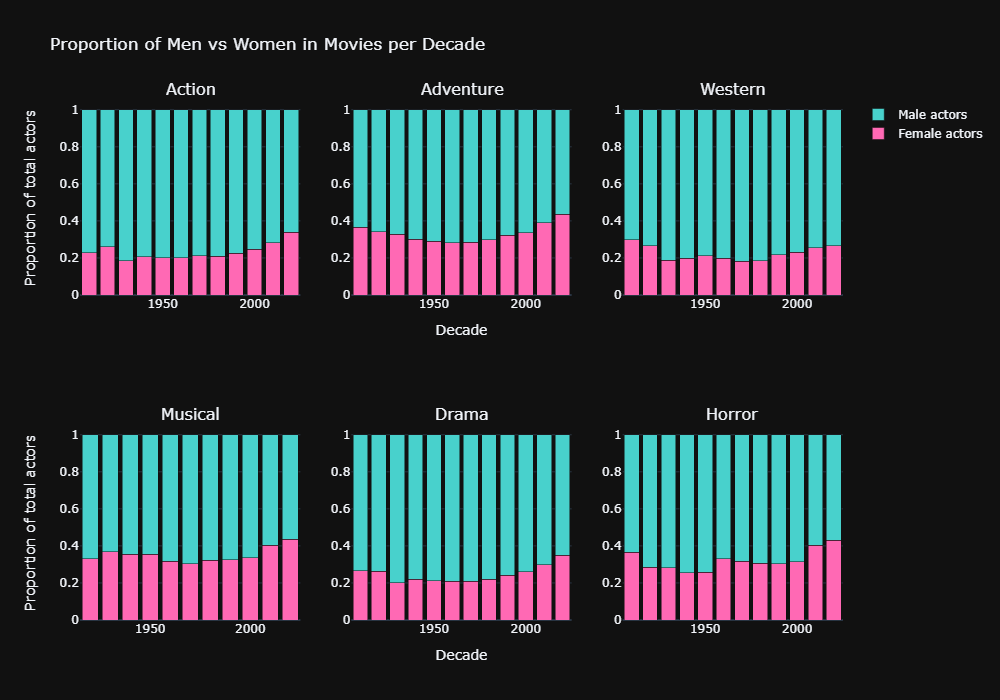

In [89]:
from plotly.subplots import make_subplots
# Create a 2x3 grid of subplots
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    subplot_proportion_men_women_per_decade(data, idx=i, subplot=subplot)

# Update layout for the entire subplot
subplot.update_layout(
    height=700,
    width=1000,
    title_text='Proportion of Men vs Women in Movies per Decade',
    xaxis2=dict(title='Decade'),
    xaxis5=dict(title='Decade'),
    yaxis=dict(title='Proportion of total actors'),
    yaxis4=dict(title='Proportion of total actors'),
    barmode='stack'
)
subplot.write_html(plot_folder+'gender_proportion_per_genre_per_decade', auto_open=True)
subplot.show('png')

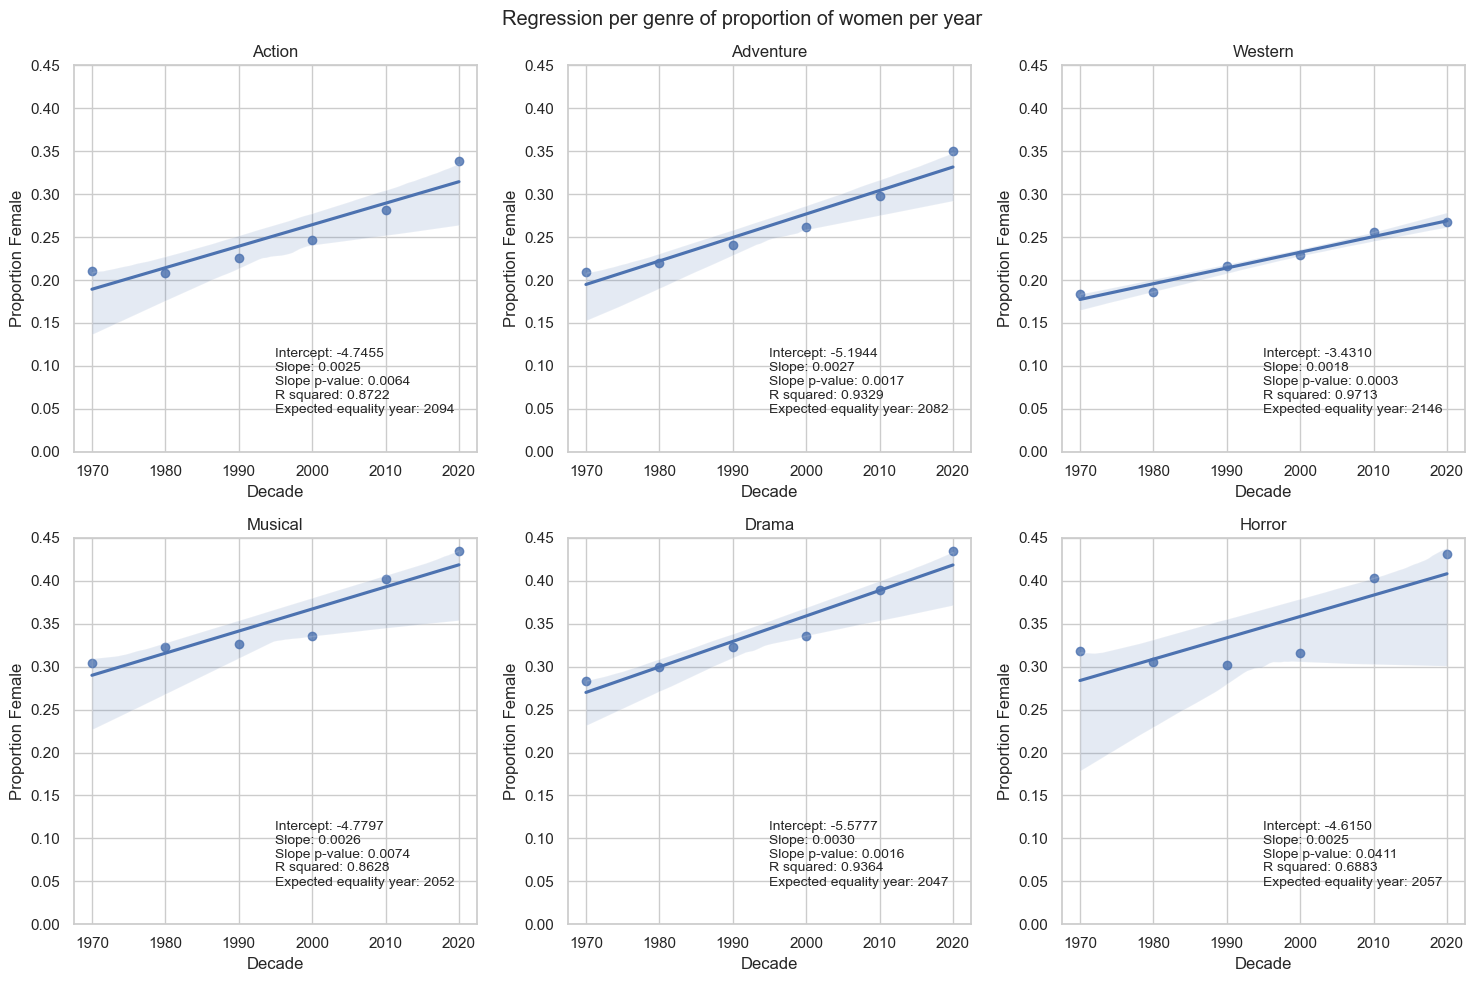

In [90]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# TODO: FONCTION TO AVOID DUPLICATE WITH ANABEL

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    final_characters_grouped_by_decade = data.groupby(data['decade'])

    proportion_female = final_characters_grouped_by_decade['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

    proportions_female_per_decade = pd.DataFrame()
    proportions_female_per_decade['decade'] = proportion_female.index
    proportions_female_per_decade['proportion'] = proportion_female.values

    proportion_female_after1970 = proportions_female_per_decade[proportions_female_per_decade['decade'] >= 1970]

    # Fit the linear model using statsmodels
    X = sm.add_constant(proportion_female_after1970['decade'])
    y = proportion_female_after1970['proportion']
    model = sm.OLS(y, X).fit()

    # Plot the data and the linear regression line
    sns.regplot(x='decade', y='proportion', data=proportion_female_after1970, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(genre)
    axes[i // 3, i % 3].set_xlabel('Decade')
    axes[i // 3, i % 3].set_ylabel('Proportion Female')
    axes[i // 3, i % 3].set_ylim([0,0.45])

    # Annotate with intercept and slope values
    intercept, slope = model.params
    p_value = model.pvalues[1]
    r_squared = model.rsquared
    fifty_fifty = (0.5-intercept)/slope
    axes[i // 3, i % 3].annotate(f'Intercept: {intercept:.4f}\nSlope: {slope:.4f}\nSlope p-value: {p_value:.4f}\nR squared: {r_squared:.4f}\nExpected equality year: {fifty_fifty:.0f}', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=10)

fig.suptitle('Regression per genre of proportion of women per year')
plt.tight_layout()
plt.show()

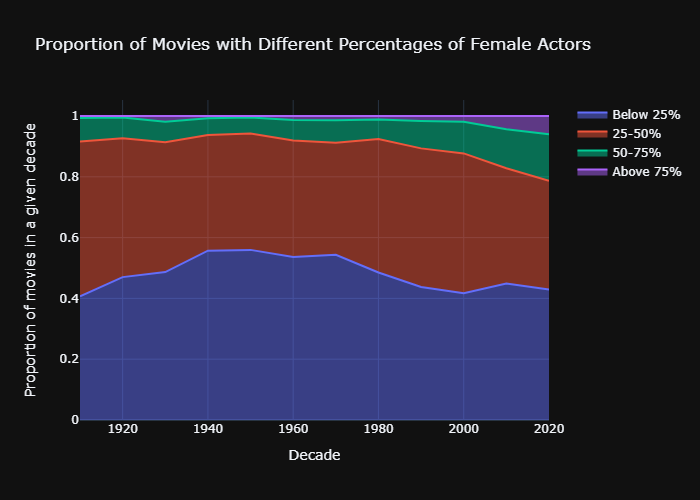

In [91]:
plot_proportion_movies_different_percentages_women(characters_data, folder=plot_folder)

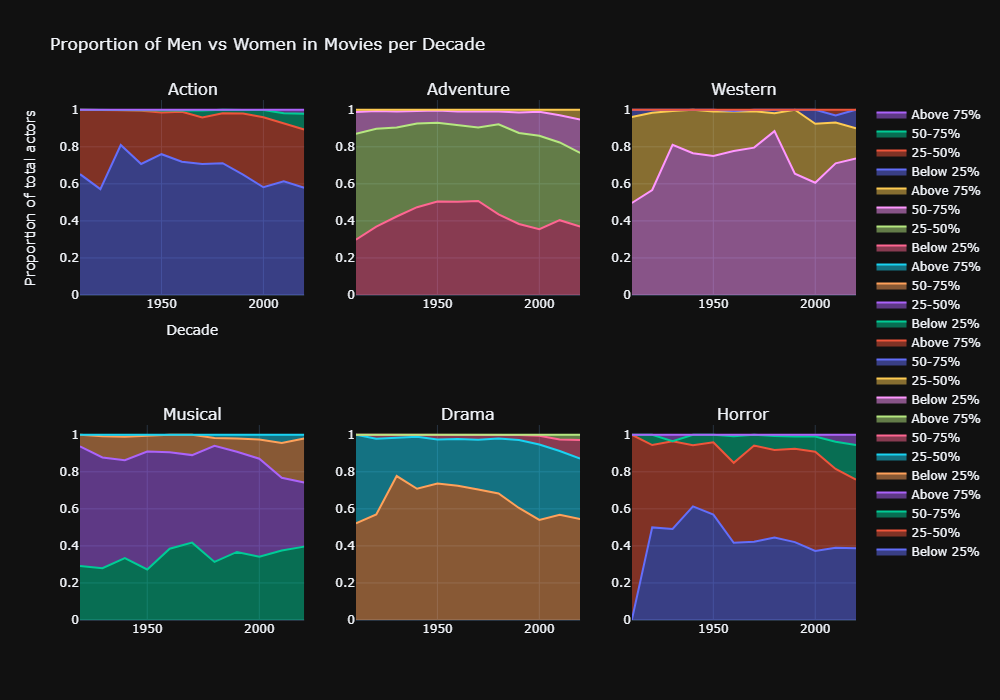

In [104]:
subplot = make_subplots(rows=2, cols=3, subplot_titles=genres)

for i, genre in enumerate(genres):
    data = subset_df(characters_with_genre, genre)
    subplot_proportion_movies_different_percentages_women(data, idx=i, subplot=subplot)

subplot.update_layout(
    height=700,
    width=1000,
    title='Proportion of Men vs Women in Movies per Decade',
    xaxis=dict(title='Decade'),
    yaxis=dict(title='Proportion of total actors'),
    barmode='stack',
    showlegend = True
)
#subplot.write_html(plot_folder+'gender_proportion_per_genre_per_decade', auto_open=True)
subplot.show('png')

# Julian's Analysis

In [ ]:
# remove nans and transform as list
movies_main_char = movie_data.copy().dropna(subset=['main character genders'])
movies_main_char['main character genders'] = movies_main_char['main character genders'].apply(ast.literal_eval)

In [ ]:
# Create a 2x3 grid of subplots
#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

#axes = axes.flatten()

for i, genre in enumerate(genres):
    data = subset_df(movies_main_char, genre)
    #axes[i].set_title(genre)
    plot_gender_ratio(data)
    plt.show()

# Adjust layout for better spacing
#plt.tight_layout()
#plt.show()